Data preprocessing :
<br>
Two data sources will be imported <br>
-"AIS_weather_h_rename_copy.csv" will be used to replace the information for true current direction and true wind direction <br>
-The resulting dataframe will be merged with the dataframe from the "AIS_weather_H_ok2_copy.csv" <br>
-The data of the journey between Ronne and Sassnitz will be omitted <br>
-The threshold for the ships manouvering speed will be 5kt (Abebe) <br>
- Update 24/6 : Reverted to true current and true wind direction, from feature importance, the feature significance makes more sense with relation to effect of current and wind to ship speed
# Update 27/7
-Change in methodology, the validation test dataset is removed as model performance is evaluated by means of k fold cross validation. Using 10 fold cross validation means that it will create its own validation dataset<br>
-Then the data will be split in 75:25 ratio (maintaining the amount of training data from previous version)
- Reason: removing June data completely will compromise the training process


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib
import time 


# Change font to latex

# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

# Load the data to the script

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]
# dfmain = dfmain.dropna()

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]
# dfpre = dfpre.dropna()



In [2]:
# Check for missing datapoints in dataset

dfmain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            7453 non-null   int64         
 1   Time                                  7453 non-null   datetime64[ns]
 2   LON                                   7453 non-null   float64       
 3   LAT                                   7453 non-null   float64       
 4   Temperature above oceans              7453 non-null   float64       
 5   Air density above oceans              7337 non-null   float64       
 6   Max wave height                       6274 non-null   float64       
 7   Swell period                          6274 non-null   float64       
 8   Wind wave period                      6274 non-null   float64       
 9   Wave period                           6274 non-null   float64       
 10  

In [3]:
# Check for missing datapoints in dataset

dfpre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  7453 non-null   datetime64[ns]
 1   LON                                   7453 non-null   float64       
 2   LAT                                   7453 non-null   float64       
 3   Eastward wind                         7453 non-null   float64       
 4   Northward wind                        7453 non-null   float64       
 5   Temperature above oceans              7453 non-null   float64       
 6   Air density above oceans              7337 non-null   float64       
 7   Max wave height                       6274 non-null   float64       
 8   Swell direction                       6274 non-null   float64       
 9   Wind wave direction                   6274 non-null   float64       
 10  

Plot to show anomalies in thesis 

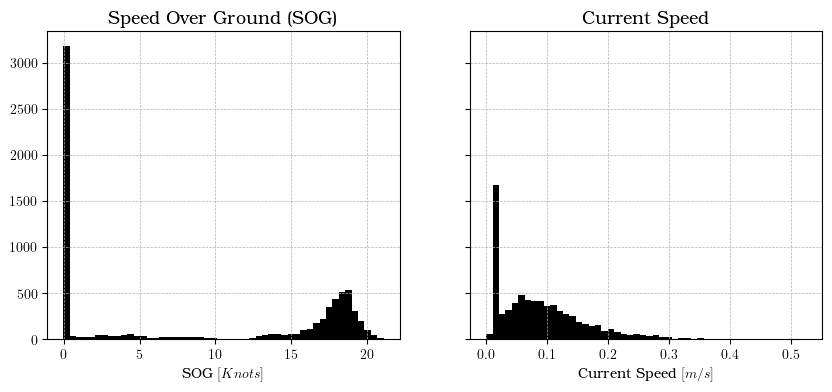

In [4]:
# Anomalies plot

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
dfmain['SOG'].hist(bins=50,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"SOG $[Knots]$")
plt.title(r"Speed Over Ground (SOG)", fontsize=13)
plt.sca(axes[1])
dfmain['Current Speed'].hist(bins=50,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"Current Speed $[m/s]$")
plt.title(r"Current Speed", fontsize=13)
plt.ylabel("")
plt.show()

Calculation of ship's true north wind and current direction

In [5]:
# Drop all dulplicate feature in dataset "AIS_weather_h_rename_copy.csv"

dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [6]:
# Imputing the information for the missing east and north current data

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [7]:
x_pre = imputer.transform(dfpre)

In [8]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [9]:
# Calculate current and wind speed

dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [10]:
# Calculate the True North wind direction and split them into quadrants

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

In [11]:
# Calculate the True North current direction and split them into quadrants

condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [12]:
# Descriptive statistics of the dataset for true north weather direction

dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813,198.585961,150.634332
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934,92.310964,100.306234
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221,0.052191,0.102997
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883,139.632096,73.919853
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080,205.028650,121.289202
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129,275.302728,227.423990
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001,359.892603,359.958291


In [13]:
# Drop further unecessary feature before meraging to main dataset

dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [14]:
# Drop the wind speed and current speed from the original dataset as it contains outlier 

dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [15]:
# Combine the the information of true north to main dataset

df = pd.concat([dfmain,dfpre],axis=1)

In [16]:
# SOG threshold according to Abebe20 and Yan21

df = df[df['SOG'] > 5 ]

In [17]:
# Length of dataset after speed filter

print(f"Length of speed filter dataset {len(df)}")

Length of speed filter dataset 3828


In [18]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.25, random_state=42)

In [19]:
# re-declare that df will be the dataframe used for training 

df = train_set

In [20]:
# Length of test dataset

print(f"Length of train dataset {len(train_set)}")
print(f"Length of test dataset {len(test_set)}")

Length of train dataset 2871
Length of test dataset 957


In [21]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

In [22]:
# Temporary export
# df.to_csv("AIS_impute_check.csv")

Data Analysis before modelling 

In [23]:
# Remove features that have no impact on model training

df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)

In [24]:
print(df_ship.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2871 entries, 984 to 6608
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Temperature above oceans              2871 non-null   float64
 1   Max wave height                       2573 non-null   float64
 2   Swell period                          2573 non-null   float64
 3   Wind wave period                      2573 non-null   float64
 4   Wave period                           2573 non-null   float64
 5   Sea surface temperature               2772 non-null   float64
 6   Combined wind waves and swell height  2573 non-null   float64
 7   Swell height                          2573 non-null   float64
 8   Wind wave height                      2573 non-null   float64
 9   Draught                               2871 non-null   float64
 10  SOG                                   2871 non-null   float64
 11  COG            

In [25]:
# Renaming Features 

df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [26]:
df_ship2 = df_ship2[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

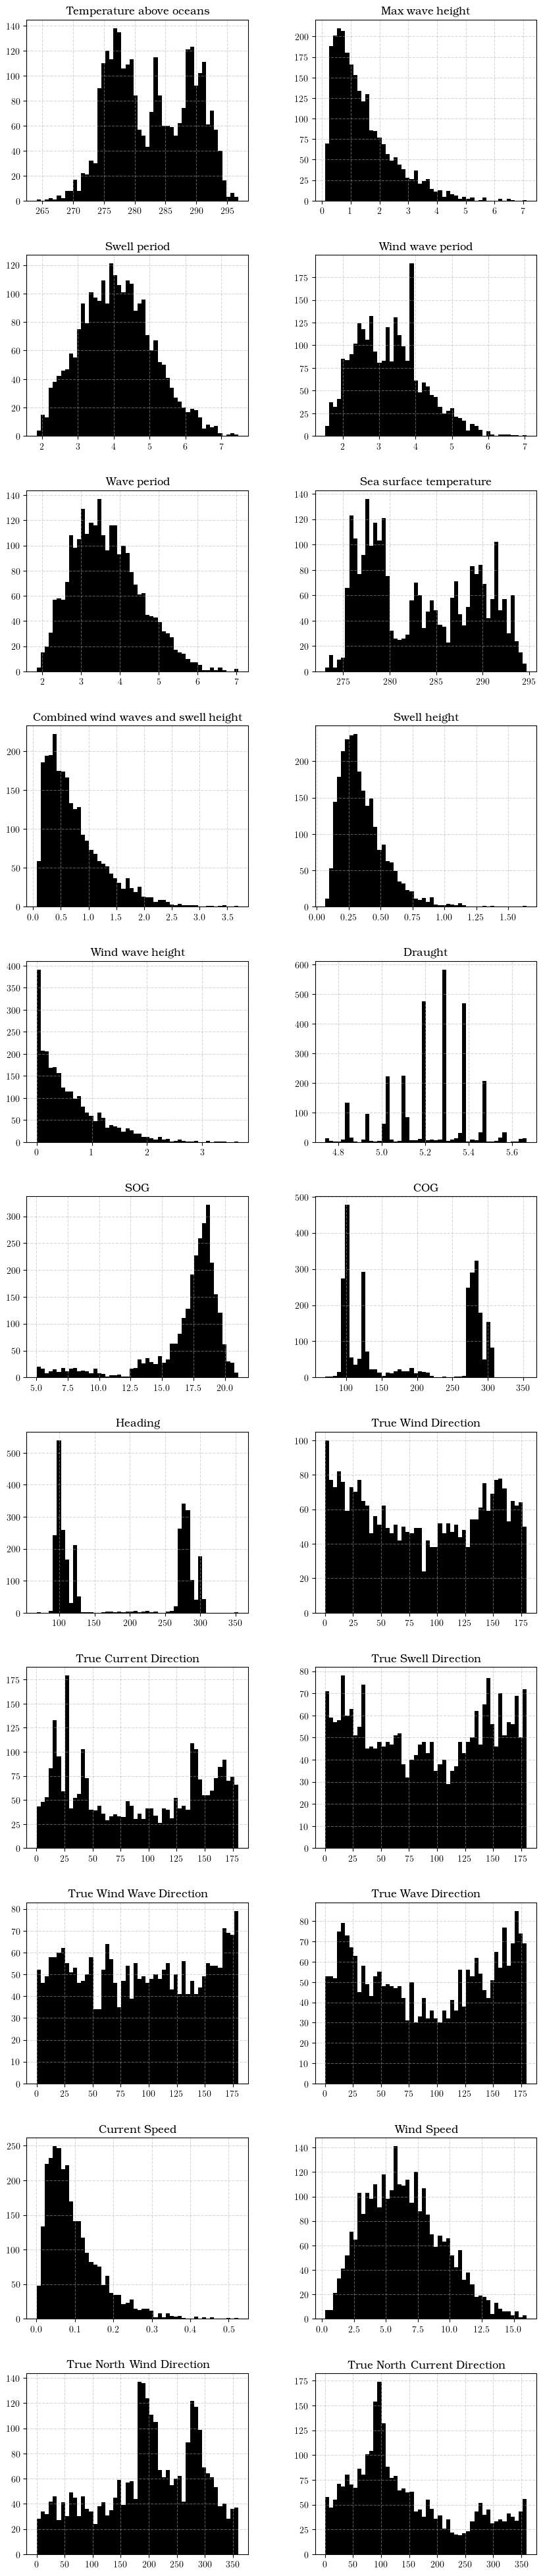

In [27]:
# plt.rcParams.update(plt.rcParamsDefault) # Alter default value 
axes = df_ship.hist(bins=50,figsize=(10,50),color='black',grid=True,layout=(11,2))
for ax in axes.flatten():
    ax.grid(True, linestyle='--', alpha=0.5)
plt.show()

Feature Selection

In [28]:
# Check correlation between variables with SOG

corr_matrix = df_ship2.corr()
print(corr_matrix["sog"])

oceantemperature       0.075340
waveheight            -0.028512
swellperiod           -0.024962
windwaveperiod        -0.038135
waveperiod            -0.022373
surftemp               0.031746
windwaveswellheight   -0.027627
swellheight           -0.030515
windwaveheight        -0.025128
draught                0.128937
sog                    1.000000
cog                    0.009329
heading                0.206758
windspeed              0.095736
curspeed               0.115846
truewinddir            0.071542
truecurrentdir         0.134674
trueswelldir          -0.011800
truewindwavedir       -0.008316
truewavedir           -0.015669
truenorthwinddir      -0.029803
truenorthcurrentdir    0.100092
Name: sog, dtype: float64


In [29]:
# Drop variables such as date from the dataset

dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
dfship_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2871 entries, 984 to 6608
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   waveheight           2573 non-null   float64
 1   swellperiod          2573 non-null   float64
 2   windwaveperiod       2573 non-null   float64
 3   waveperiod           2573 non-null   float64
 4   windwaveswellheight  2573 non-null   float64
 5   swellheight          2573 non-null   float64
 6   windwaveheight       2573 non-null   float64
 7   draught              2871 non-null   float64
 8   sog                  2871 non-null   float64
 9   cog                  2871 non-null   float64
 10  heading              2871 non-null   float64
 11  windspeed            2871 non-null   float64
 12  curspeed             2871 non-null   float64
dtypes: float64(13)
memory usage: 314.0 KB


In [30]:
def correlation_heatmap(df,fontsize):
    correlations = df.corr()
    # Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    colormap = sns.color_palette("Reds")
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale = fontsize)
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',cmap="mako",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
                # ,annot_kws={'fontsize': 12, 'color':'k', 'alpha': 1})
    plt.show();

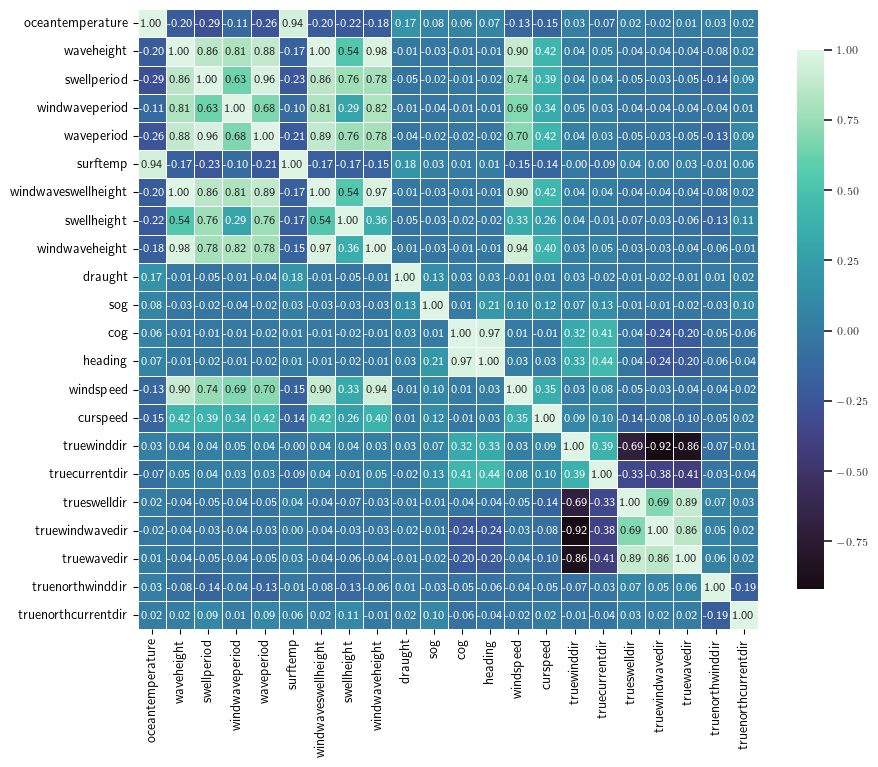

In [31]:
# Plot heatmap of overall dataset

df_ship_ovr = df_ship2
correlation_heatmap(df_ship_ovr,.7)

Scientific Justification of HCF:

-According to Bitner Gregersen, the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore SWH and WWH is to be dropped.<br>
-According to Mori, through wave spectrum, the maximum wave height can be approximated, therefore max wave height can be dropped as well <br>
-According to Torsetshaugen, The type of dominating wave (Wind wave/Swell) can be predicted from the significant through an equation which include the significant wave height and a certain threshold, therefore, it is decided that the wind wave period, swell period and consequently the true wind wave direction and true swell direction is to be dropped.<br>
-Drop The True Wind and True North direction and replace with the True North direction
- Update 24/6 : Decision reverted to drop true directions

In [32]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight',
                        'windwaveperiod','swellperiod',
                        'truewindwavedir','trueswelldir',
                        'truenorthcurrentdir','truenorthwinddir'],axis=1)

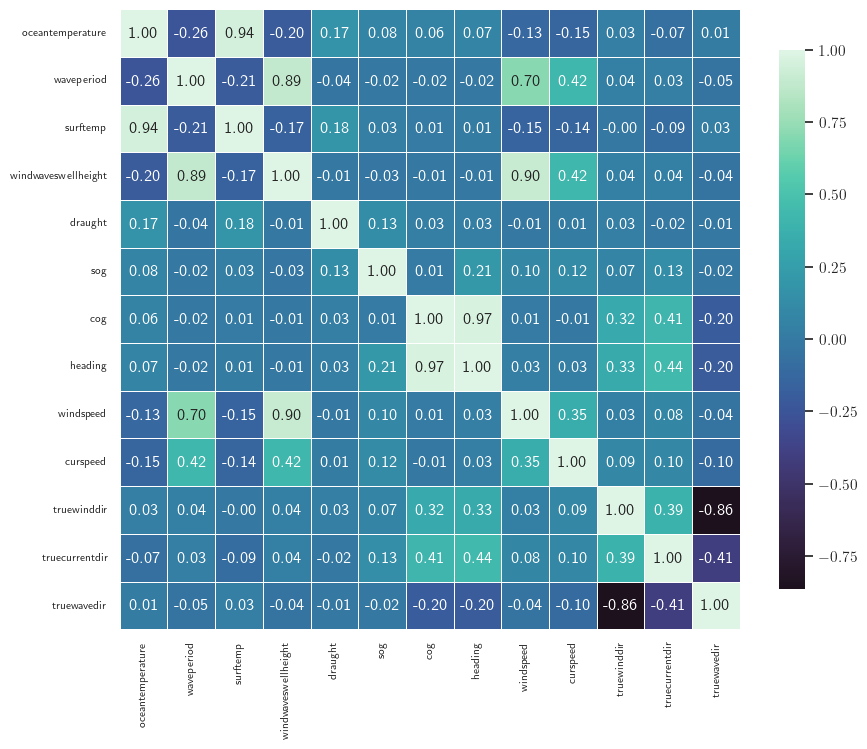

In [33]:
# Heatmap for training feature

correlation_heatmap(df_ship2,1)

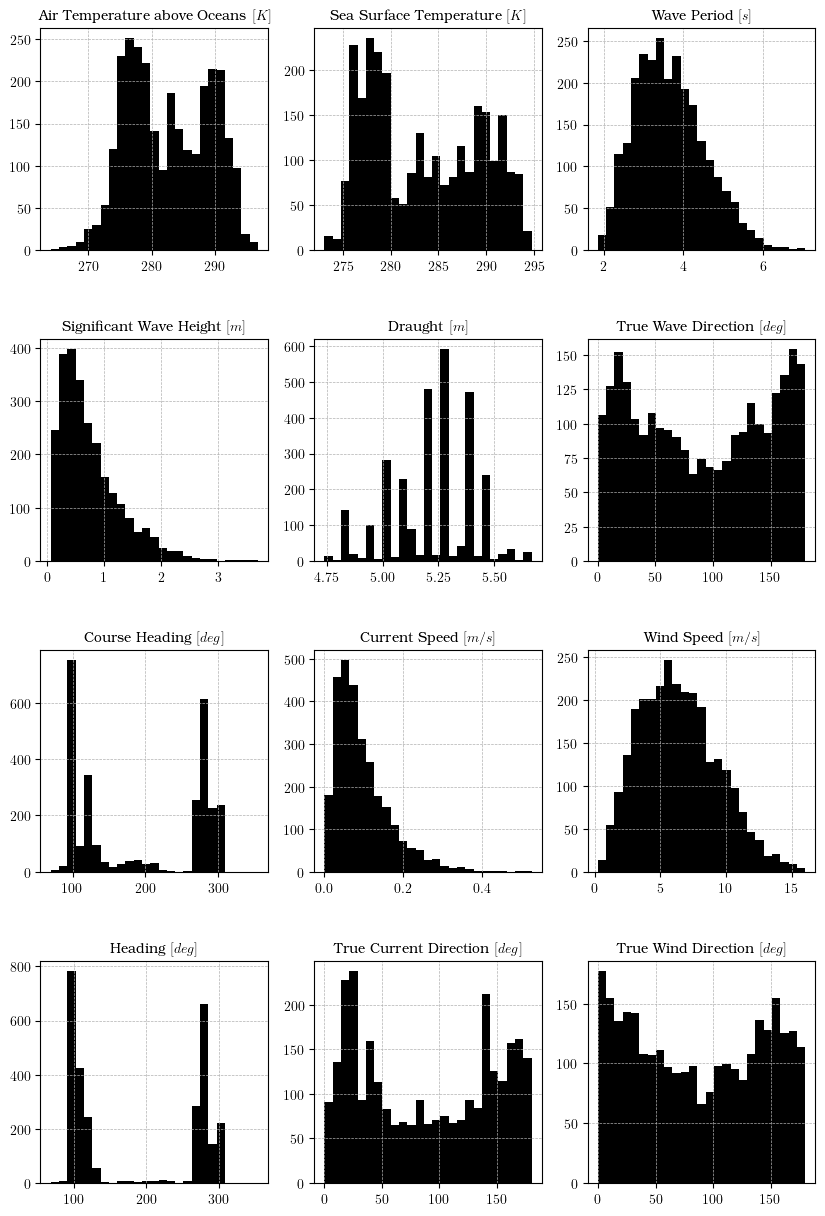

In [34]:
# demonstrate how to toggle the display of different elements:
# Histogram plot of final features and labels for training

fs = 10

plt.rcParams.update(plt.rcParamsDefault)
# Parameter to plot in nice latex fonts
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

oceantemp = df_ship2['oceantemperature']
waveperiod = df_ship2['waveperiod']
surftemp = df_ship2['surftemp']
sigwave = df_ship2['windwaveswellheight']
draught = df_ship2['draught']
sog = df_ship2['sog']
cog = df_ship2['cog']
hdg = df_ship2['heading']
windspeed = df_ship2['windspeed']
curspeed = df_ship2['curspeed']
truewavedir = df_ship2['truewavedir']
truewind = df_ship2['truewinddir']
truecurrent = df_ship2['truecurrentdir']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 15))

axes[0, 0].hist(oceantemp,bins=25,color='black')
axes[0, 0].set_title(r'Air Temperature above Oceans $[K]$', fontsize=fs)
axes[0, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 1].hist(surftemp,bins=25,color='black')
axes[0, 1].set_title(r'Sea Surface Temperature $[K]$', fontsize=fs)
axes[0, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[0, 2].hist(waveperiod,bins=25,color='black')
axes[0, 2].set_title(r'Wave Period $[s]$', fontsize=fs)
axes[0, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 0].hist(sigwave,bins=25,color='black')
axes[1, 0].set_title(r'Significant Wave Height $[m]$', fontsize=fs)
axes[1, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 1].hist(draught  ,bins=25,color='black')
axes[1, 1].set_title(r'Draught $[m]$', fontsize=fs)
axes[1, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[1, 2].hist(truewavedir,bins=25,color='black')
axes[1, 2].set_title(r'True Wave Direction $[deg]$', fontsize=fs)
axes[1, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 0].hist(cog,bins=25,color='black')
axes[2, 0].set_title(r'Course Heading $[deg]$', fontsize=fs)
axes[2, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 1].hist(curspeed,bins=25,color='black')
axes[2, 1].set_title(r'Current Speed $[m/s]$', fontsize=fs)
axes[2, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[2, 2].hist(windspeed,bins=25,color='black')
axes[2, 2].set_title(r'Wind Speed $[m/s]$', fontsize=fs)
axes[2, 2].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 0].hist(hdg,bins=25,color='black')
axes[3, 0].set_title(r'Heading $[deg]$', fontsize=fs)
axes[3, 0].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 1].hist(truecurrent,bins=25,color='black')
axes[3, 1].set_title(r'True Current Direction $[deg]$', fontsize=fs)
axes[3, 1].grid(True,linestyle = '--', linewidth = 0.5)

axes[3, 2].hist(truewind,bins=25,color='black')
axes[3, 2].set_title(r'True Wind Direction $[deg]$', fontsize=fs)
axes[3, 2].grid(True,linestyle = '--', linewidth = 0.5)

fig.subplots_adjust(hspace=0.4)
plt.show()

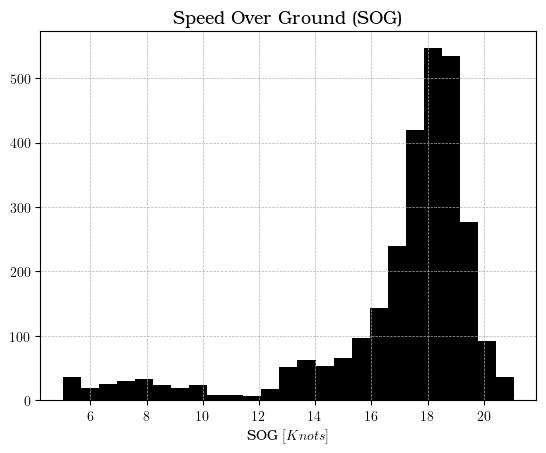

In [35]:
df_ship2['sog'].hist(bins=25,color='black')
# Parameter to plot in nice latex fonts
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
plt.grid(linestyle = '--', linewidth = 0.5)
plt.xlabel(r"SOG $[Knots]$")
plt.title(r"Speed Over Ground (SOG)", fontsize=13)
plt.show()

Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [36]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)

KNNImputer(n_neighbors=50)

In [37]:
X = imputer.transform(df_ship2)

In [38]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [39]:
print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2871 entries, 984 to 6608
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     2871 non-null   float64
 1   waveperiod           2871 non-null   float64
 2   surftemp             2871 non-null   float64
 3   windwaveswellheight  2871 non-null   float64
 4   draught              2871 non-null   float64
 5   sog                  2871 non-null   float64
 6   cog                  2871 non-null   float64
 7   heading              2871 non-null   float64
 8   windspeed            2871 non-null   float64
 9   curspeed             2871 non-null   float64
 10  truewinddir          2871 non-null   float64
 11  truecurrentdir       2871 non-null   float64
 12  truewavedir          2871 non-null   float64
dtypes: float64(13)
memory usage: 314.0 KB
None


Preparation of Training data

In [40]:
x_train = df_ship2tr.drop(['sog'],axis=1)
y_train = df_ship2tr.sog

In [41]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2871


In [42]:
x_train.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewinddir,truecurrentdir,truewavedir
count,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000,2871.000000
mean,282.711463,3.656657,283.402541,0.749322,5.224037,196.472472,187.875727,6.419314,0.096717,87.140814,89.147281,91.737736
std,6.490218,0.822037,5.733749,0.505372,0.180681,85.932980,88.470768,2.970628,0.070303,55.959201,57.534502,55.525201
min,264.076782,1.857891,273.048584,0.065236,4.739825,69.768055,67.902386,0.248587,0.000980,0.000973,0.248414,0.126279
25%,277.132385,3.073893,278.129395,0.382885,5.109460,102.584274,100.859321,4.130620,0.046116,34.193279,31.007741,39.117658
50%,282.624023,3.572011,282.833252,0.637942,5.282741,188.007511,124.651764,6.150542,0.078068,84.788656,86.775515,92.280129
75%,288.823120,4.139376,288.861084,0.948298,5.376956,282.260913,279.191630,8.359405,0.127678,140.583469,143.321028,143.331269
max,296.830322,7.047197,294.751709,3.698143,5.667030,355.065691,354.145635,16.010816,0.525174,179.773797,179.997073,179.918071


In [43]:
y_train.describe()

count    2871.000000
mean       16.913445
std         3.176740
min         5.027200
25%        16.561214
50%        17.936689
75%        18.718229
max        21.070514
Name: sog, dtype: float64

Modelling using Random Forest Regressor 

In [44]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr = RandomForestRegressor(random_state=42)
start_rf = time.time()
model_rfr_ftr.fit(x_train,y_train)
end_rf = time.time()
print(f"Training time: {end_rf-start_rf:0.4}s ")

Training time: 4.152s 


HPO RFR for validation data

In [45]:
from sklearn.ensemble import RandomForestRegressor
model_rfr_ftr_hpov = RandomForestRegressor(n_estimators = 100,
                                            min_samples_split = 2,
                                            min_samples_leaf = 1,
                                            max_features = 10,
                                            max_depth=120,
                                            random_state=42)

# # Prev HPO: (n_estimators = 900,min_samples_split = 2,min_samples_leaf = 2,# max_features = 9,max_depth=200,random_state=42)

start_rfo = time.time()
model_rfr_ftr_hpov.fit(x_train,y_train)
end_rfo = time.time()
print(f"Training time: {end_rfo-start_rfo:0.4}s ")

Training time: 3.528s 


Modelling using ETR

In [46]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr = ExtraTreesRegressor(random_state=42)
start_et = time.time()
model_etr.fit(x_train,y_train)
end_et = time.time()
print(f"Training time: {end_et-start_et:0.4}s ")

Training time: 0.9623s 


HPO ETR for validation data

In [47]:
from sklearn.ensemble import ExtraTreesRegressor

model_etr_hpov = ExtraTreesRegressor(random_state=42,
                                n_estimators=800,
                                min_samples_split=9,
                                min_samples_leaf=1,
                                max_features=12,
                                max_depth=120,
                                )
# Prev HPO (random_state=42,n_estimators=600,max_depth=10)

start_eto = time.time()
model_etr_hpov.fit(x_train,y_train)
end_eto = time.time()
print(f"Training time: {end_eto-start_eto:0.4}s")

Training time: 4.446s


Modelling using Decision Tree Regressor

In [48]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
start_dtr = time.time()
model_dtr.fit(x_train,y_train)
end_dtr = time.time()
print(f"Training time: {end_dtr-start_dtr:0.4}s")

Training time: 0.04323s


HPO DTR for validation data

In [49]:
from sklearn.tree import DecisionTreeRegressor
model_dtr_hpov = DecisionTreeRegressor(min_samples_split=7,
                                  min_samples_leaf=10,
                                  max_features=12,
                                  max_depth=8)
# Old HPO (min_samples_split=2,min_samples_leaf=3,max_features=12,max_depth=10)
start_dtro = time.time()
model_dtr_hpov.fit(x_train,y_train)
end_dtro = time.time()
print(f"Training time: {end_dtro-start_dtro:0.4}s")

Training time: 0.02087s


Modelling using Multiple Linear Regression

In [50]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
start_mlr = time.time()
model_mlr.fit(x_train,y_train)
end_mlr = time.time()
print(f"Training time: {end_mlr-start_mlr:0.4}s")

Training time: 0.003999s


Save model to local directory

In [51]:
# # # Saving the model to local directory

# filename = 'savemodel_rfr_ftr.sav'
# joblib.dump(model_rfr_ftr,filename)

# filename = 'savemodel_rfr_ftr_hpov.sav'
# joblib.dump(model_rfr_ftr_hpov,filename)

# filename = 'savemodel_etr.sav'
# joblib.dump(model_etr,filename)

# filename = 'savemodel_etr_hpov.sav'
# joblib.dump(model_etr_hpov,filename)

# filename = 'savemodel_dtr_ftr.sav'
# joblib.dump(model_dtr,filename)

# filename = 'savemodel_dtr_hpov.sav'
# joblib.dump(model_dtr_hpov,filename)

# filename = 'savemodel_mlr_ftr.sav'
# joblib.dump(model_mlr,filename)

Model Evaluation

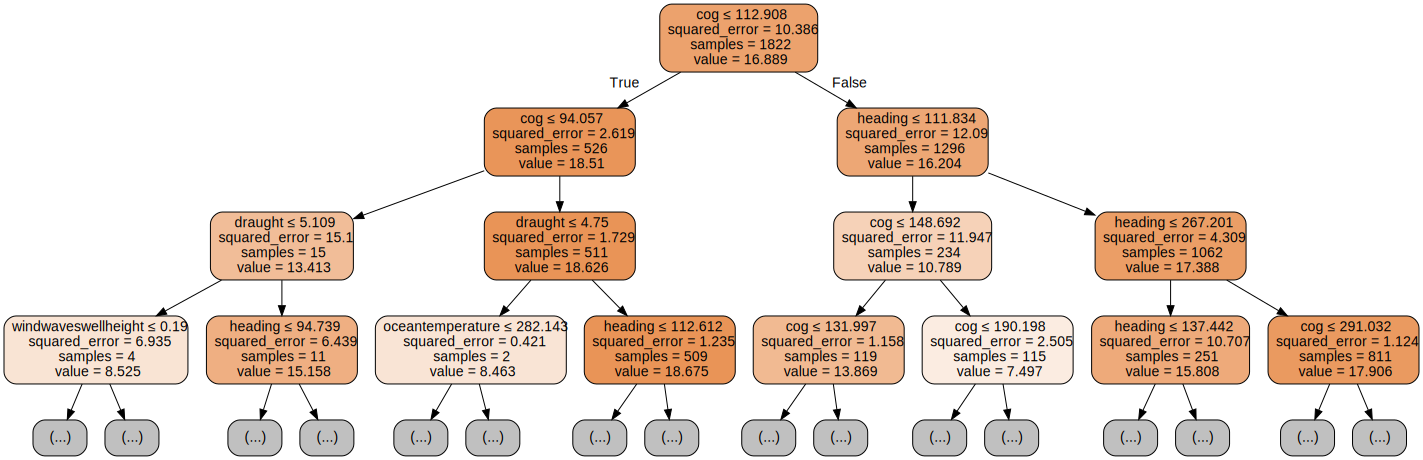

In [52]:
# Plot tree using graphviz, generate 2nd tree in forest (Graphviz must be installed in local computer)

from IPython.display import display
from sklearn import tree
import graphviz

dot_data2 = tree.export_graphviz(model_rfr_ftr.estimators_[2], 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data2))

# # Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data2)
# graph.format = 'png'
# graph.render('rf_tree_test_it2',view=True)

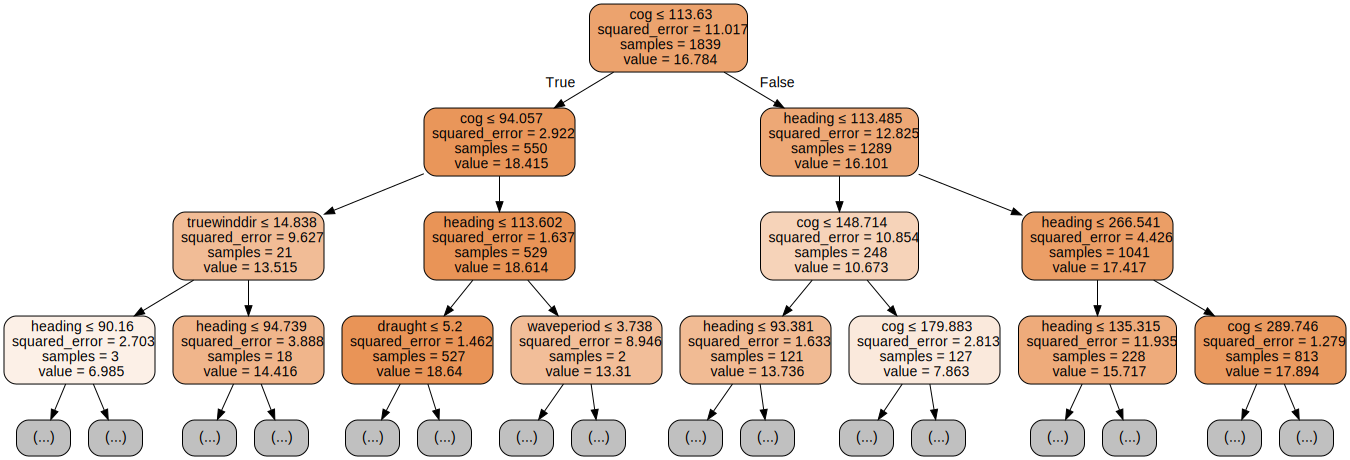

In [53]:
# Generate 5th tree in forest

dot_data5 = tree.export_graphviz(model_rfr_ftr.estimators_[5], 
                  feature_names=x_train.columns.values.tolist(),  
                #   class_names=class_names,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                   max_depth=3,
                           )

display(graphviz.Source(dot_data5))

# # Only uncomment when about to generate PNG file, it will create source file that cannot be ignored by git

# graph = graphviz.Source(dot_data5)
# graph.format = 'png'
# graph.render('rf_tree_test_it5',view=True)

In [54]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp.sort_values(by=['Importance'],ascending=False))


In [55]:
def plot_feature_importance(model_type,names,model_name):

    importance = model_type.feature_importances_

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(5,4))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],color='black')
    #Add chart labels
    plt.title(f"Feature Importance of {model_name}")
    plt.grid(linestyle = '--', linewidth = 0.4,axis='x')
    plt.xlabel('Feature Importance')
    plt.xlim(0,0.7)
    plt.ylabel('Feature Names')


                     Importance
heading                0.589198
cog                    0.332940
draught                0.020339
truecurrentdir         0.008141
surftemp               0.007309
curspeed               0.007200
waveperiod             0.007052
truewinddir            0.006264
truewavedir            0.005476
windspeed              0.005467
windwaveswellheight    0.005464
oceantemperature       0.005149


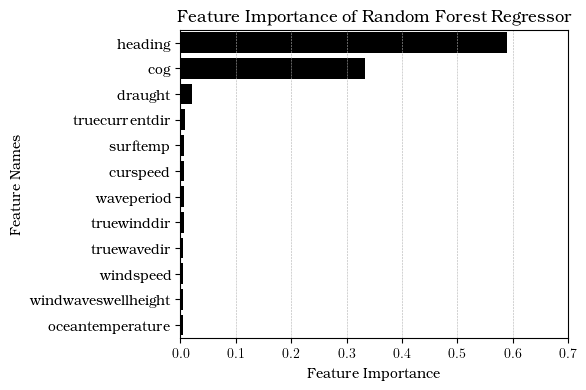

In [56]:
model_importance(model_rfr_ftr)
plot_feature_importance(model_rfr_ftr,x_train.columns,'Random Forest Regressor')
plt.show()


                     Importance
cog                    0.641570
heading                0.248161
truecurrentdir         0.020911
draught                0.017050
waveperiod             0.012611
curspeed               0.012045
windwaveswellheight    0.011094
windspeed              0.008428
truewavedir            0.007435
surftemp               0.007293
oceantemperature       0.007275
truewinddir            0.006126


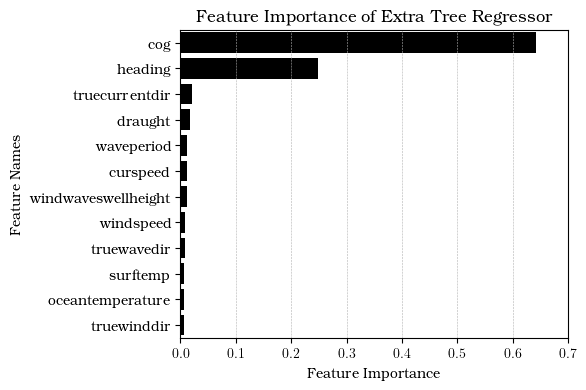

In [57]:
model_importance(model_etr)
plot_feature_importance(model_etr,x_train.columns,'Extra Tree Regressor')
plt.show()

                     Importance
heading                0.614719
cog                    0.304900
draught                0.019937
curspeed               0.009780
surftemp               0.009180
truecurrentdir         0.009141
truewinddir            0.007215
waveperiod             0.006356
windwaveswellheight    0.005285
windspeed              0.004946
oceantemperature       0.004672
truewavedir            0.003869


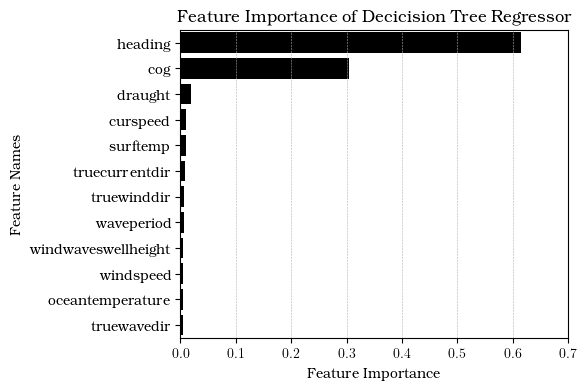

In [58]:
model_importance(model_dtr)
plot_feature_importance(model_dtr,x_train.columns,'Decicision Tree Regressor')
plt.show()

In [59]:
def evaluate(model, features_x, labels_y):
    from sklearn.model_selection import cross_val_score

    score_r2 = cross_val_score(model,features_x,labels_y,
                           scoring='r2',cv=10)
    rsquared = score_r2.mean()
    stadev_rsquared = score_r2.std()
    max_rsquared = score_r2.max()
    min_rsquared = score_r2.min()

    score_expVar = cross_val_score(model,features_x,labels_y,
                           scoring='explained_variance',cv=10)
    expVar = score_expVar.mean()
    stadev_expVar = score_expVar.std()
    max_expVar = score_expVar.max()
    min_expVar = score_expVar.min()

    score_MAE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_mean_absolute_error',cv=10)
    MAE = -score_MAE.mean()
    stadev_MAE = score_MAE.std()
    max_MAE = -score_MAE.max()
    min_MAE = -score_MAE.min()

    score_MAD = cross_val_score(model,features_x,labels_y,
                           scoring='neg_median_absolute_error',cv=10)
    MAD = -score_MAD.mean()
    stadev_MAD = score_MAD.std()
    max_MAD = -score_MAD.max()
    min_MAD = -score_MAD.min()



    score_MSE = cross_val_score(model,features_x,labels_y,
                           scoring='neg_root_mean_squared_error',cv=10)
    score_RMSE = np.sqrt(-score_MSE)
    RMSE = score_RMSE.mean()
    stadev_RMSE = score_RMSE.std()
    max_RMSE = score_RMSE.max()
    min_RMSE = score_RMSE.min()


    print(f"Model Performance of {model}")
    print(f"R^2 = {rsquared:0.4f}, std = {stadev_rsquared:0.4f}, max = {max_rsquared:0.4f}, min = {min_rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}, std = {stadev_expVar:0.4f}, max = {max_expVar:0.4f}, min = {min_expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}, std = {stadev_MAE:0.4f}, max = {max_MAE:0.4f}, min = {min_MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}, std = {stadev_RMSE:0.4f}, max = {max_RMSE:0.4f}, min = {min_RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}, std = {stadev_MAD:0.4f}, max = {max_MAD:0.4f}, min = {min_MAD:0.4f}\n")

    return score_r2,score_expVar,score_MAE,score_RMSE,score_MAD        

Evaluation of RFR

In [60]:
r2_rf,expVar_rf,MAE_rf,RMSE_rf,MAD_rf = evaluate(model_rfr_ftr,x_train,y_train)

Model Performance of RandomForestRegressor(random_state=42)
R^2 = 0.8917, std = 0.0210, max = 0.9106, min = 0.8405
explained Variance = 0.8921, std = 0.0208, max = 0.9108, min = 0.8414
MAE = 0.6564, std = 0.0371, max = 0.6103, min = 0.7288
RMSE = 1.0151, std = 0.0445, max = 1.0907, min = 0.9451
MAD = 0.4459, std = 0.0311, max = 0.4100, min = 0.5260



In [61]:
# Optimised model performance

r2_rfo,expVar_rfo,MAE_rfo,RMSE_rfo,MAD_rfo = evaluate(model_rfr_ftr_hpov,x_train,y_train)

Model Performance of RandomForestRegressor(max_depth=120, max_features=10, random_state=42)
R^2 = 0.8946, std = 0.0215, max = 0.9157, min = 0.8434
explained Variance = 0.8950, std = 0.0214, max = 0.9158, min = 0.8443
MAE = 0.6492, std = 0.0404, max = 0.6033, min = 0.7324
RMSE = 1.0078, std = 0.0475, max = 1.0963, min = 0.9443
MAD = 0.4448, std = 0.0385, max = 0.4104, min = 0.5447



Evaluation of ETR

In [62]:
r2_et,expVar_et,MAE_et,RMSE_et,MAD_et = evaluate(model_etr,x_train,y_train)

Model Performance of ExtraTreesRegressor(random_state=42)
R^2 = 0.9135, std = 0.0175, max = 0.9335, min = 0.8667
explained Variance = 0.9138, std = 0.0172, max = 0.9336, min = 0.8679
MAE = 0.6138, std = 0.0415, max = 0.5502, min = 0.6759
RMSE = 0.9594, std = 0.0394, max = 1.0289, min = 0.9082
MAD = 0.4310, std = 0.0232, max = 0.4011, min = 0.4711



In [63]:
# Optimised model performance 

r2_eto,expVar_eto,MAE_eto,RMSE_eto,MAD_eto = evaluate(model_etr_hpov,x_train,y_train)

Model Performance of ExtraTreesRegressor(max_depth=120, max_features=12, min_samples_split=9,
                    n_estimators=800, random_state=42)
R^2 = 0.9091, std = 0.0194, max = 0.9348, min = 0.8591
explained Variance = 0.9094, std = 0.0192, max = 0.9349, min = 0.8602
MAE = 0.6230, std = 0.0428, max = 0.5676, min = 0.6936
RMSE = 0.9710, std = 0.0472, max = 1.0433, min = 0.9039
MAD = 0.4430, std = 0.0249, max = 0.4156, min = 0.4843



Evaluation of DTR

In [64]:
r2_dt,expVar_dt,MAE_dt,RMSE_dt,MAD_dt = evaluate(model_dtr,x_train,y_train)

Model Performance of DecisionTreeRegressor()
R^2 = 0.7982, std = 0.0383, max = 0.8588, min = 0.7361
explained Variance = 0.8040, std = 0.0295, max = 0.8509, min = 0.7602
MAE = 0.8992, std = 0.0457, max = 0.7979, min = 0.9575
RMSE = 1.1829, std = 0.0335, max = 1.2244, min = 1.1198
MAD = 0.5819, std = 0.0465, max = 0.5034, min = 0.6453



In [65]:
# Optimised model performance

r2_dto,expVar_dto,MAE_dto,RMSE_dto,MAD_dto = evaluate(model_dtr_hpov,x_train,y_train)

Model Performance of DecisionTreeRegressor(max_depth=8, max_features=12, min_samples_leaf=10,
                      min_samples_split=7)
R^2 = 0.8525, std = 0.0300, max = 0.8881, min = 0.7792
explained Variance = 0.8529, std = 0.0300, max = 0.8884, min = 0.7797
MAE = 0.7599, std = 0.0587, max = 0.6680, min = 0.8812
RMSE = 1.0963, std = 0.0591, max = 1.1760, min = 0.9964
MAD = 0.4931, std = 0.0457, max = 0.4089, min = 0.5933



Evaluation of MLR 

In [66]:
r2_mlr,expVar_mlr,MAE_mlr,RMSE_mlr,MAD_mlr = evaluate(model_mlr,x_train,y_train)

Model Performance of LinearRegression()
R^2 = 0.6534, std = 0.0796, max = 0.7680, min = 0.4996
explained Variance = 0.6538, std = 0.0797, max = 0.7681, min = 0.4998
MAE = 1.1867, std = 0.0735, max = 1.1191, min = 1.3711
RMSE = 1.3560, std = 0.0842, max = 1.5478, min = 1.2630
MAD = 0.9518, std = 0.0501, max = 0.8421, min = 1.0219



Prediction vs Actual

In [67]:
# Parameter to reset plot properties to default and change the font to tex

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})

Learning Curves

In [68]:
# Functions for RMSE and Rsquared plots
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit ,learning_curve

def learn_plotrmse(model,x_data,y_data,model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model, X=x_data, y=y_data,
                                                        cv=10, train_sizes=np.linspace(0.1, 1.0, 20),
                                                        n_jobs=-1,scoring="neg_root_mean_squared_error")
	# Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    #
    # Calculate training and test mean and std
    #
    train_scores = np.sqrt(-train_scores)
    test_scores = np.sqrt(-test_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=r'Training Error')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='d', markersize=5, linestyle='--', label=r'Validation Error')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(fr'Learning Curve of {model_name}')
    plt.xlabel(r'Training Data Size')
    plt.ylabel(r'RMSE [knots]')
    plt.xlim(200,2700)
    plt.ylim(0,2)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(loc='lower right')
    # plt.show()
    
def learn_plotr2(model,x_data,y_data,model_name):
    train_sizes, train_scores, test_scores = learning_curve(estimator = model, X=x_data, y=y_data,
                                                        cv=10, train_sizes=np.linspace(0.1, 1.0,20),
                                                        n_jobs=-1,scoring="r2")
	# Parameter to plot in nice latex fonts
    plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
    #
    # Calculate training and test mean and std
    #
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    #
    # Plot the learning curve
    #
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label=r'Training Score')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', marker='d', markersize=5, linestyle='--', label=r'Validation Score')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.title(fr'Learning Curve of {model_name}')
    plt.xlabel(r'Training Data Size')
    plt.ylabel(r'Rsquared')
    plt.ylim(0.5,1)
    plt.xlim(200,2700)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.legend(loc='lower right')
    # plt.show()


Understanding Effect of Hyperparameter optimisation

Learning Curve DTR

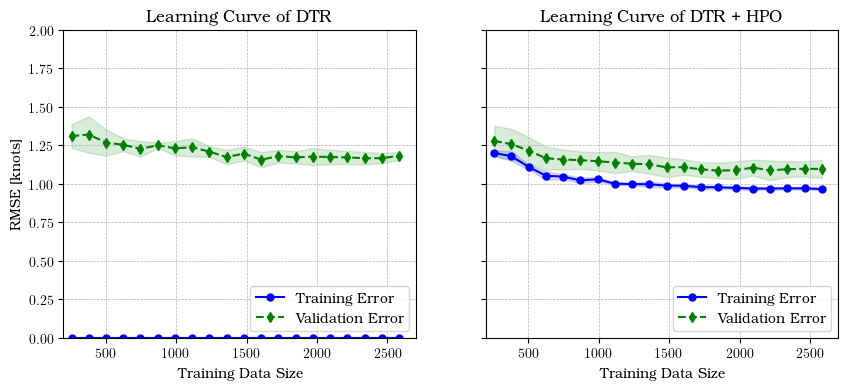

In [69]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_dtr,x_train,y_train,'DTR')
plt.sca(axes[1])
learn_plotrmse(model_dtr_hpov,x_train,y_train,'DTR + HPO')
plt.ylabel("")
plt.show()

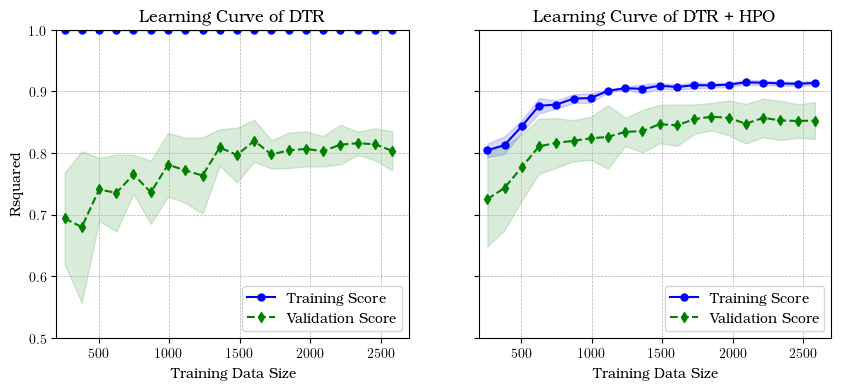

In [70]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_dtr,x_train,y_train,'DTR')
plt.sca(axes[1])
learn_plotr2(model_dtr_hpov,x_train,y_train,'DTR + HPO')
plt.ylabel("")
plt.show()

Learning Curve RFR

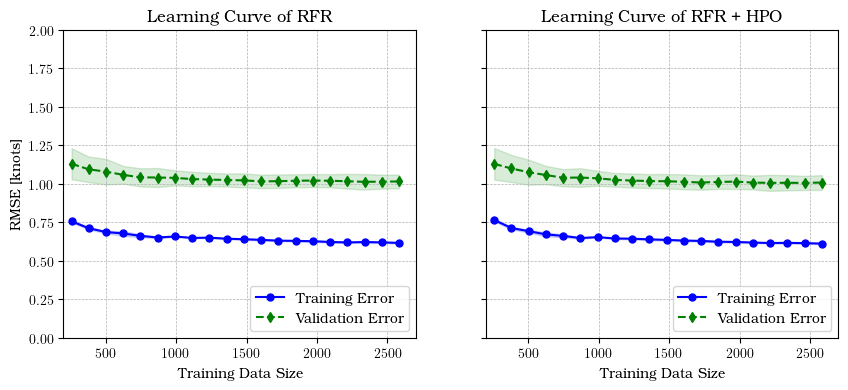

In [71]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_rfr_ftr,x_train,y_train,'RFR')
plt.sca(axes[1])
learn_plotrmse(model_rfr_ftr_hpov,x_train,y_train,'RFR + HPO')
plt.ylabel("")
plt.show()

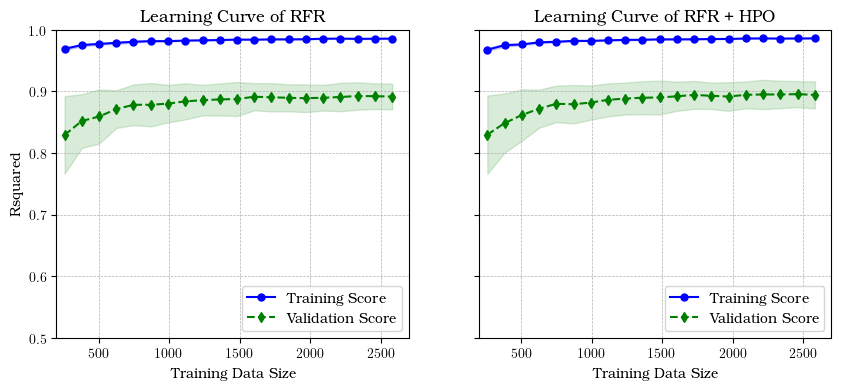

In [72]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_rfr_ftr,x_train,y_train,'RFR')
plt.sca(axes[1])
learn_plotr2(model_rfr_ftr_hpov,x_train,y_train,'RFR + HPO')
plt.ylabel("")
plt.show()

Learning Curve ETR

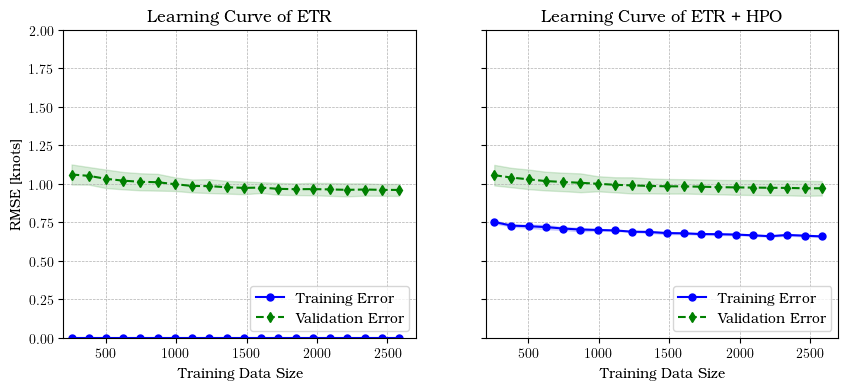

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotrmse(model_etr,x_train,y_train,'ETR')
plt.sca(axes[1])
learn_plotrmse(model_etr_hpov,x_train,y_train,'ETR + HPO')
plt.ylabel("")
plt.show()

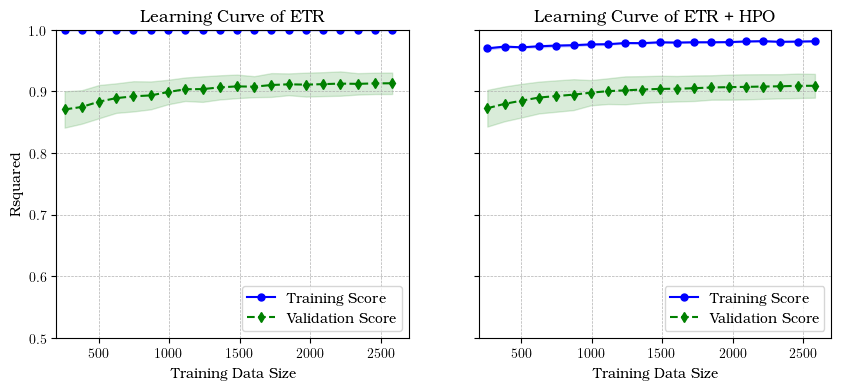

In [74]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
learn_plotr2(model_etr,x_train,y_train,'ETR')
plt.sca(axes[1])
learn_plotr2(model_etr_hpov,x_train,y_train,'ETR + HPO')
plt.ylabel("")
plt.show()

Box plot for evaluations

<Figure size 640x480 with 0 Axes>

<Figure size 500x300 with 0 Axes>

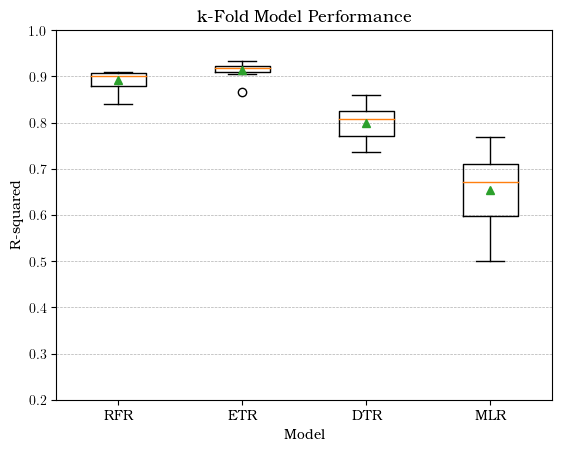

In [91]:
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores = [r2_rf,r2_et,r2_dt,r2_mlr]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("k-Fold Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.ylim(0.2,1.0)
plt.boxplot(scores,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR', 'MLR'])
plt.show()

<Figure size 500x300 with 0 Axes>

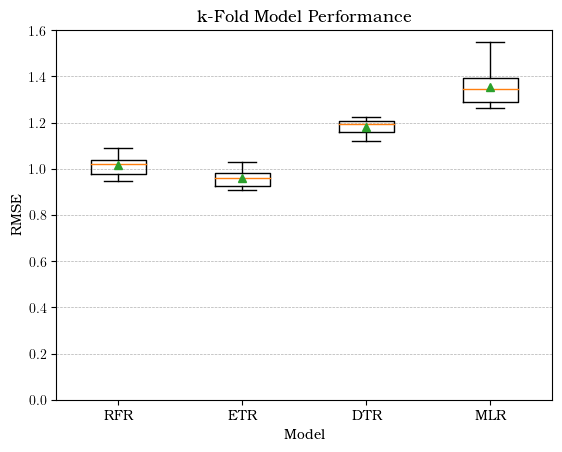

In [92]:
plt.rcParams.update({
	"text.usetex": True,
	"font.family": "serif",
	"font.serif": "bookman",
	})
scores_rmse = [np.abs(RMSE_rf),np.abs(RMSE_et),np.abs(RMSE_dt),np.abs(RMSE_mlr)]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("k-Fold Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.ylim(0,1.6)
plt.yscale('linear')
ax.boxplot(scores_rmse,showmeans=True)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR', 'MLR'])
plt.show()

Comparison for optimised model

In [119]:
def r2_plot_opt(r2_mod1,r2_mod1opt,r2_mod2,r2_mod2opt,r2_mod3,r2_mod3opt):
    scores_opt = [r2_mod1,r2_mod1opt,r2_mod2,r2_mod2opt,r2_mod3,r2_mod3opt]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("R-squared")
    plt.xlabel("Model")
    plt.ylim(0.2,1.0)
    plt.yscale('linear')
    ax.boxplot(scores_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

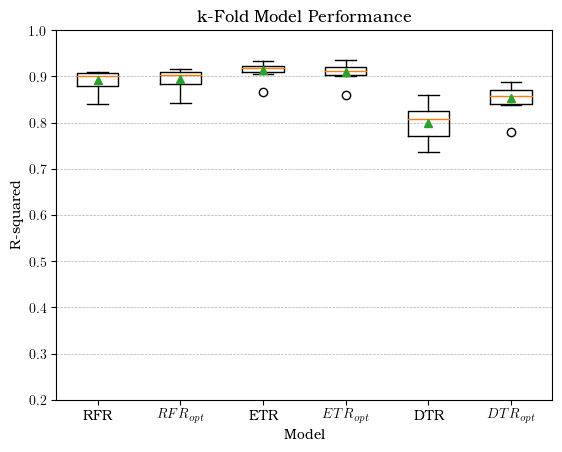

In [120]:
r2_plot_opt(r2_rf,r2_rfo,r2_et,r2_eto,r2_dt,r2_dto)
plt.show()

In [121]:
def rmse_plot_opt(rmse_mod1,rmse_mod1opt,rmse_mod2,rmse_mod2opt,rmse_mod3,rmse_mod3opt):
    rmse_opt = [rmse_mod1,rmse_mod1opt,rmse_mod2,rmse_mod2opt,rmse_mod3,rmse_mod3opt]
    # fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("RMSE [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(rmse_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

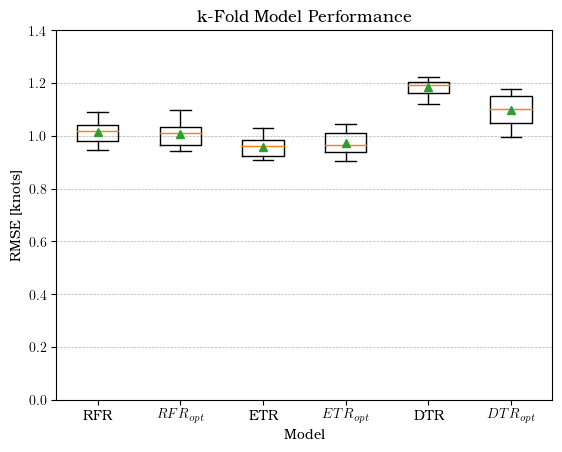

In [122]:
rmse_plot_opt(RMSE_rf,RMSE_rfo,RMSE_et,RMSE_eto,RMSE_dt,RMSE_dto)
plt.show()


In [123]:
def mae_plot_opt(mae_mod1,mae_mod1opt,mae_mod2,mae_mod2opt,mae_mod3,mae_mod3opt):
    mae_opt = [mae_mod1,mae_mod1opt,mae_mod2,mae_mod2opt,mae_mod3,mae_mod3opt]
    fig = plt.figure(figsize=(5,3))
    # Creating axes instance
    fig,ax = plt.subplots() 
    plt.title("k-Fold Model Performance")
    plt.ylabel("MAE [knots]")
    plt.xlabel("Model")
    plt.yscale('linear')
    plt.ylim(0,1.4)
    ax.boxplot(mae_opt,showmeans=True)
    plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
    ax.set_xticklabels([r'RFR', r'$RFR_{opt}$',
                        r'ETR', r'$ETR_{opt}$',
                        r'DTR',r'$DTR_{opt}$'])

<Figure size 500x300 with 0 Axes>

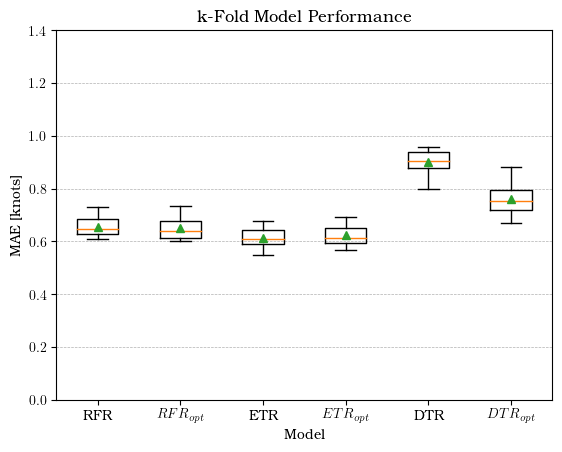

In [124]:
mae_plot_opt(-MAE_rf,-MAE_rfo,-MAE_et,-MAE_eto,-MAE_dt,-MAE_dto)
plt.show()